# Overwatch Ult Charge

In [47]:
from __future__ import print_function

import collections
import colorsys
import itertools
import os
import pickle
import random
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tqdm

from PIL import ImageFont, ImageDraw, Image 

import keras

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import models
from keras.models import load_model
from skimage import color, data, filters, io, transform

import conf
import core

from core import Bbox, load_straight_dataset, load_slanted_dataset
from utils import crop_region, create_grid, create_rand_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print('Done loading environment.')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done loading environment.


# Display a random Overwatch frame

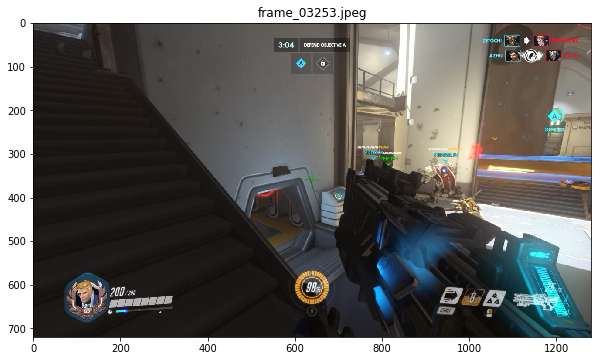

In [41]:
# Uncomment if you want a single image
# random.seed(231)

dataset_dirs = ['/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset', '/Users/ctang/Documents/overwatch_object_detection/videos/01_26_2018_22_41_04_02/98']
dirname = dataset_dirs[1]

files = os.listdir(dirname)
imgfile = random.choice(files)
image = mpimg.imread(os.path.join(dirname, imgfile))

plt.imshow(image)
plt.title(imgfile)
plt.show()

# Display region containing Ult Charge

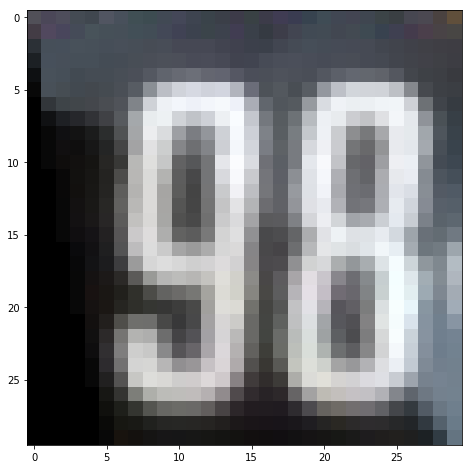

In [43]:
# imgfile = 'frame_05514.png'
# imgfile = 'frame_03338.jpeg'
tens_bbox = Bbox(x=2, y=0, w=15, h=30)
ones_bbox = Bbox(x=17, y=0, w=15, h=30)
ult_charge_bbox = Bbox(x=625, y=590, w=30, h=30)
shear = transform.AffineTransform(shear=0.2)
warped_size = (28, 28)
    
# imgfile = random.choice(files)
image = mpimg.imread(os.path.join(dirname, imgfile))
ult_bbox = Bbox(x=625, w=30, y=590, h=30)
region = crop_region(image, ult_bbox)
region = transform.warp(region, inverse_map=shear)
solo_ones_bbox = Bbox(x=0, y=0, w=23, h=30)
ones_digit = cv2.resize(crop_region(region, solo_ones_bbox), warped_size, interpolation=cv2.INTER_LINEAR)
plt.imshow(region)
plt.show()

# Train an MNIST model

In [23]:
model = core.mnist_model(force_train=False)

print('Loading data and input shape...')
(_, _), (x_test, y_test), _ = core.load_mnist_data()

print('Evaluating model on test data...')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Loading pretrained model...
Loading data and input shape...
Evaluating model on test data...
Test loss: 0.0297505717966
Test accuracy: 0.9897


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Exploring MNIST

Show some samples of the MNIST dataset.

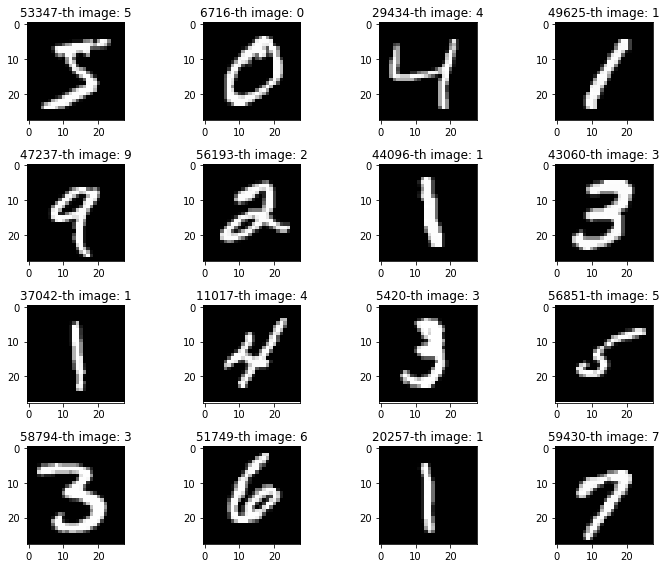

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
for i, region in enumerate(random.sample(range(len(x_train)), 16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title("%d-th image: %d" % (region, y_train[i]))
plt.tight_layout()
plt.show()

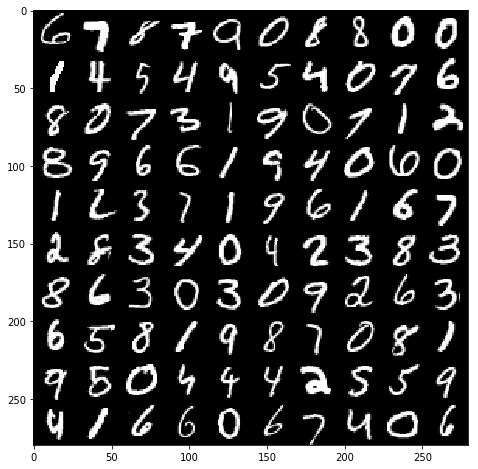

In [17]:
plt.imshow(create_rand_grid(x_train, 10, 10), cmap='gray')

## Show the average image for each digit

/Users/ctang/miniconda3/envs/cs231n/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


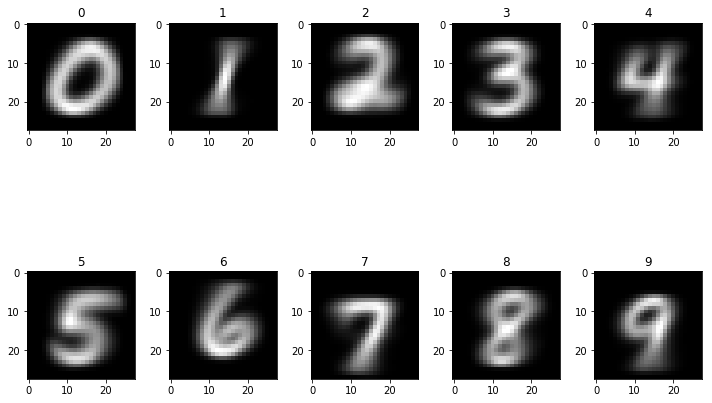

In [18]:
fig = plt.figure()
for i in range(10):
    values = x_train[y_train == i]
    avg = np.mean(values, axis=0).astype(np.uint8)
    plt.subplot(2, 5, i+1)
    plt.imshow(avg, cmap='gray')
    plt.title(i)
fig.tight_layout()
fig.show()

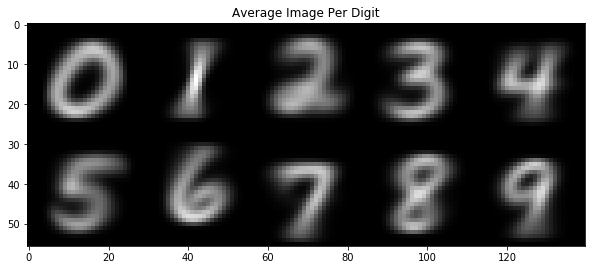

In [19]:
averages = np.array([np.mean(x_train[y_train == i], axis=0).astype(np.uint8) for i in range(10)])
plt.imshow(create_grid(averages, 2, 5), cmap='gray')
plt.title("Average Image Per Digit")
plt.show()

# Exploring Overwatch Dataset

## Display tens and ones digits

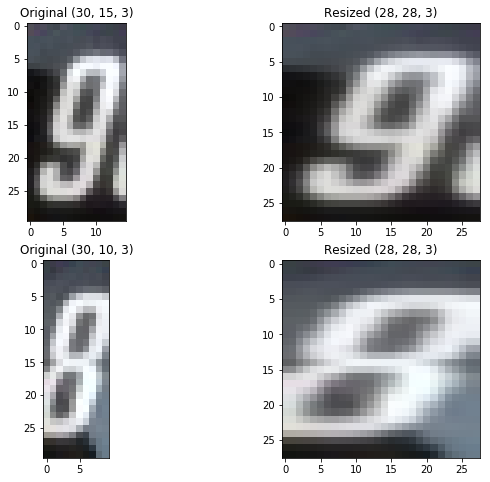

In [44]:
tens = crop_region(image, Bbox(x=625, y=590, w=15, h=30))
plt.subplot(2, 2, 1)
plt.imshow(tens)
plt.title("Original %s" % str(tens.shape))

tens_resized = cv2.resize(tens, (28, 28))
plt.subplot(2, 2, 2)
plt.imshow(tens_resized)
plt.title("Resized %s" % str(tens_resized.shape))

ones = crop_region(image, Bbox(x=640, y=590, w=10, h=30))
plt.subplot(2, 2, 3)
plt.imshow(ones)
plt.title("Original %s" % str(ones.shape))

ones_resized = cv2.resize(ones, (28, 28))
plt.subplot(2, 2, 4)
plt.imshow(ones_resized)
plt.title("Resized %s" % str(ones_resized.shape))

plt.show()

Text(0.5,1,'actual=8, predicted=8')

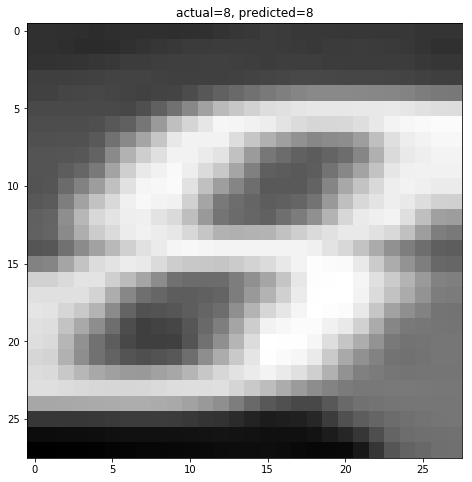

In [45]:
N, H, W, C = 1, 28, 28, 1
region = ones_resized[:,:,1].reshape(N, H, W, C)
result = model.predict(region)
plt.imshow(color.rgb2gray(ones_resized), cmap='gray')
plt.title("actual=%d, predicted=%d" % (8, np.argmax(result)))

# Prepare an evaluation dataset

In [38]:
dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'

# Ult charge at 53%
start = 5474
end = 5541
fifty_three = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]

# Ult charge at 54%
start = 5542
end = 5574
fifty_four = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]
print('Done')

Done


Deserialized validation dataset from Pickle file.
Loaded x_valid: (202, 28, 28, 1)
Loaded y_valid: (202, 10)
Test loss: 1.48412906651
Test accuracy: 0.584158415842


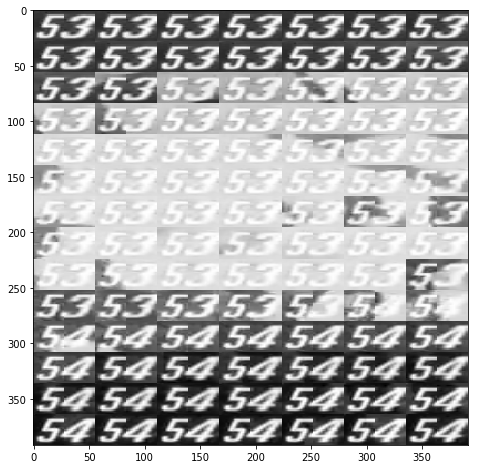

In [39]:
tens_bbox = Bbox(x=625, y=590, w=15, h=30)
ones_bbox = Bbox(x=640, y=590, w=10, h=30)

def load_sheared_dataset():
    """
    Parse out tens and ones digits from each image.
    The digits are sheared.
    """
    if os.path.exists(conf.OW_ULT_CHARGE_VALID_DATASET_PKL):
        with open(conf.OW_ULT_CHARGE_VALID_DATASET_PKL, 'rb') as f:
            x_valid, y_valid = pickle.load(f)
            print('Deserialized validation dataset from Pickle file.')
    else:
        x_valid = []
        y_valid = []

        for i, imgfile in tqdm.tqdm(enumerate(fifty_three)):
            five = crop_region(mpimg.imread(imgfile), tens_bbox)
            three = crop_region(mpimg.imread(imgfile), ones_bbox)

            x_valid.append(five)
            x_valid.append(three)
            y_valid.append(5)
            y_valid.append(3)

        print('Done producing 5 and 3 images.')

        for i, imgfile in tqdm.tqdm(enumerate(fifty_four)):
            five = crop_region(mpimg.imread(imgfile), tens_bbox)
            four = crop_region(mpimg.imread(imgfile), ones_bbox)

            x_valid.append(five)
            x_valid.append(four)
            y_valid.append(5)
            y_valid.append(4)

        print('Done producing 5 and 4 images.')

        with open(conf.OW_ULT_CHARGE_VALID_DATASET_PKL, 'wb') as f:
            pickle.dump((x_valid, y_valid), f)
            print('Done serializing validation dataset.')
    
    return x_valid, y_valid

def preprocess(x):
    """
    Convert the image regions from HxWx4 to 28x28x1
    and grayscale them.
    """
    warped = cv2.resize(x, (28, 28), interpolation=cv2.INTER_LINEAR)
    gray = color.rgb2gray(warped)
    return gray

def visualize(images, N=16):
    sqrts = {
        1: 1,
        2: 4,
        3: 9,
        4: 16,
        5: 25,
        6: 36,
        7: 49,
        8: 64,
        9: 81,
        10: 100
    }
    
    reverse_sqrts = { sqrts[k]:k for k in sqrts }
    

# Load dataset and display samples
x_valid, y_valid = load_sheared_dataset()
# for i, region in enumerate(random.sample(range(len(x_valid)), 16)):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(x_valid[i])
#     plt.title("%d-th image: %d" % (region, y_valid[i]))

# plt.tight_layout()
# plt.show()

x_valid = np.array(list(map(preprocess, x_valid)))
plt.imshow(create_grid(x_valid[:200], 14, 14), cmap='gray')
x_valid = x_valid.reshape(len(x_valid), 28, 28, 1)
y_valid = keras.utils.to_categorical(np.array(y_valid), conf.NUM_CLASSES)

print("Loaded x_valid:", x_valid.shape)
print("Loaded y_valid:", y_valid.shape)

score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print actual and predicted results per image.
# with open('results_slanted.csv', 'w') as f:
#     for i, pair in enumerate(zip(x_val, y_val)):
#         x, y = pair
#         actual = np.argmax(y)
#         predicted = np.argmax(model.predict(x.reshape(1, 28, 28, 1)))
#         f.write("[%d] actual=%d, predicted=%d\n" % (i, actual, predicted))

Show the activations for each convolutional layer. The more black squares, the fewer the activations, the less likely an accurate prediction can be made.

/Users/ctang/miniconda3/envs/cs231n/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Predicted result: 3


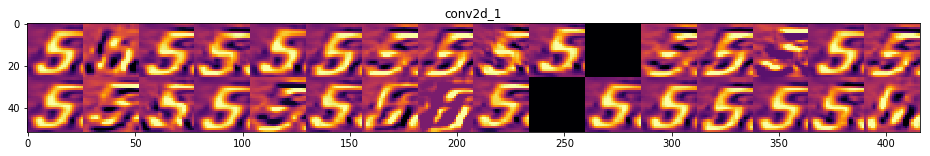

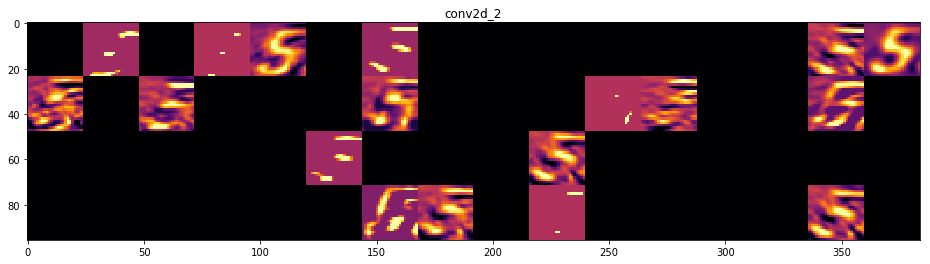

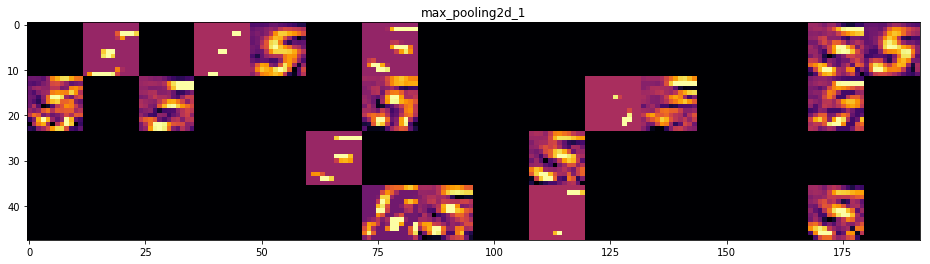

In [46]:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
img_tensor = np.expand_dims(x_valid[100], axis=0)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[1]

layer_names = [layer.name for layer in model.layers[:3]]
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    _, size, _, n_channels = layer_activation.shape
    n_rows = n_channels // images_per_row
    
    display_grid = np.zeros( (size * n_rows, size * images_per_row) )
    
    for col in range(n_rows):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')
print("Predicted result:", np.argmax(model.predict(img_tensor)))

# Data Augmentation
## Synthetic Data
Since we're simply classifying the Ult digits in Overwatch, we can generate more of them to create a training set.


pseudocode:

    for every number:
        for 1000 font colors:
            for 1000 canvas colors:
                for -5 to 5 pixel left-right shifts:
                    for -5 to 5 pixel up-down shifts:
                        for 5 types of rotations:
                            generate image

Links:
* [HTML Color Picker](https://htmlcolorcodes.com/)
* [skimage shearing](http://scikit-image.org/docs/0.13.x/api/skimage.transform.html#skimage.transform.AffineTransform)
* [Converting np to PIL image](https://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap)
* [Drawing custom fonts](http://effbot.org/imagingbook/imagedraw.htm)
* [Drawing custom fonts 2](http://www.codesofinterest.com/2017/07/more-fonts-on-opencv.html)
* [How to shear an image](https://stackoverflow.com/questions/24191545/skewing-or-shearing-an-image-in-python)

Sheared in 0.001107 seconds.
Sheared in 0.000749 seconds.


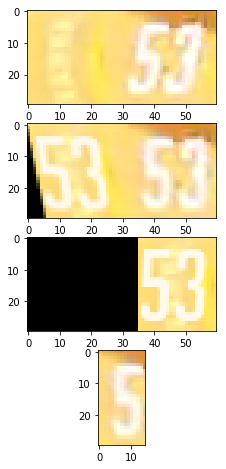

In [33]:
# tens = crop_region(image, Bbox(x=625, y=590, w=30, h=30))
space_tens = crop_region(image, Bbox(x=595, y=590, w=60, h=30))

# color palette
skin_color = (246, 233, 191)
lighter_skin_color = (252,241,202)
even_lighter = (255, 250, 235)

original_region = Image.fromarray(np.uint8(space_tens*255))
sheared_region = Image.fromarray(np.uint8(space_tens*255))
orig_sheared = Image.fromarray(np.uint8(space_tens*255))

draw = ImageDraw.Draw(sheared_region)
font = ImageFont.truetype("data/big_noodle_titling_oblique.ttf", 32)
draw.text((0, -2), "53", font=font, fill=even_lighter)

draw2 = ImageDraw.Draw(orig_sheared)
font2 = ImageFont.truetype("data/big_noodle_titling_oblique.ttf", 32)
draw2.text((0, -2), "53", font=font, fill=even_lighter)

affine_tf = transform.AffineTransform(shear=0.2, translation=(0, 0))

start = time.time()
sheared_region = transform.warp(sheared_region, inverse_map=affine_tf)
end = time.time()

print("Sheared in %f seconds." % (end - start))

translation_only = transform.AffineTransform(translation=(-35, 0))

start = time.time()
orig_sheared = transform.warp(orig_sheared, inverse_map=translation_only)
end = time.time()

print("Sheared in %f seconds." % (end - start))

nrows = 4
ncols = 1

plt.subplot(nrows, ncols, 1)
plt.imshow(original_region)
plt.subplot(nrows, ncols, 2)
plt.imshow(sheared_region)
plt.subplot(nrows, ncols, 3)
plt.imshow(orig_sheared)
plt.subplot(nrows, ncols, 4)

h, w, c = sheared_region.shape
sheared_region = crop_region(sheared_region, Bbox(x=w//2+2, y=0, w=w//4, h=h))
plt.imshow(sheared_region)
plt.show()

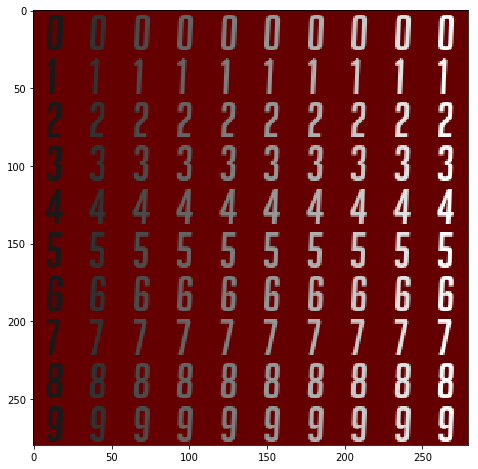

In [34]:
def draw_ult_charge(image):
    canvas_size = (28, 28)
    canvas_color = (0, 0, 0)
    canvas_color = (255, 250, 235)
    upper_lefthand_corner = (8, -3)
    font = ImageFont.truetype(os.path.join(os.getcwd(), "data/big_noodle_titling_oblique.ttf"), 32)
    region = crop_region(image, Bbox(x=200, y=200, w=28, h=28))
    plt.imshow(region)
    pil_region = Image.fromarray(np.uint8(region*255))
    canvas = ImageDraw.Draw(pil_region)
    canvas.text(upper_lefthand_corner, "9", font=font, fill=canvas_color)
    plt.imshow(pil_region)

def gen_synthetic_train_data():
    h, w = 28, 28
    canvas_size = (h, w)
    canvas_color = (100, 0, 0)
    n_rows = 10
    n_cols = 10
    font = ImageFont.truetype(os.path.join(os.getcwd(), "data/big_noodle_titling_oblique.ttf"), 32)
    upper_lefthand_corner = (8, -3)
    
    row_col_pairs = [ (row, col) for row in range(n_rows) for col in range(n_cols) ]
    
    region_list = []
    display_grid = np.zeros( (n_rows*h, n_cols*w, 3) ).astype(np.uint8)

    for number in range(10):
        for color in zip(range(25, 255, 25), range(25, 255, 25), range(25, 255, 25)):
            r,g,b = color
            pil_region = PIL.Image.new("RGB", canvas_size, canvas_color)
            canvas = ImageDraw.Draw(pil_region)
            canvas.text(upper_lefthand_corner, str(number), font=font, fill=(r,g,b))
            region = np.array(pil_region)
            region_list.append(region)

    
    for idx, (row, col) in enumerate([(row, col) for row in range(n_rows) for col in range(n_cols)]):
        display_grid[row*h:row*h+h, col*w:col*w+w, :] = region_list[idx]

    return region_list, display_grid

# draw_ult_charge(image)
region_list, display_grid = gen_synthetic_train_data()
plt.imshow(display_grid)

Mix and match various text and canvas colors for digits 0 through 9.

In [19]:
canvas_size = (28, 28)
upper_lefthand_corner = (8, -3)

font = ImageFont.truetype(os.path.join(os.getcwd(), "data/big_noodle_titling_oblique.ttf"), 32)
canvas_colors = [(r,g,b) for r in range(0, 256, 52) for g in range(0, 256, 52) for b in range(0, 256, 52)]
text_colors = [(r,g,b) for r in range(0, 256, 52) for g in range(0, 256, 52) for b in range(0, 256, 52)]

region_list = []
for number in range(10):
    print('Working on number=', number)
    for canvas_color in canvas_colors:
        for text_color in text_colors:
            pil_region = PIL.Image.new("RGB", canvas_size, canvas_color)
            canvas = ImageDraw.Draw(pil_region)
            canvas.text(upper_lefthand_corner, str(number), font=font, fill=text_color)
            region = np.array(pil_region)
            region_list.append(region)

Working on number= 0
Working on number= 1
Working on number= 2
Working on number= 3
Working on number= 4
Working on number= 5
Working on number= 6
Working on number= 7
Working on number= 8
Working on number= 9


Display a sample of the generated images.

Number of generated images: 156250


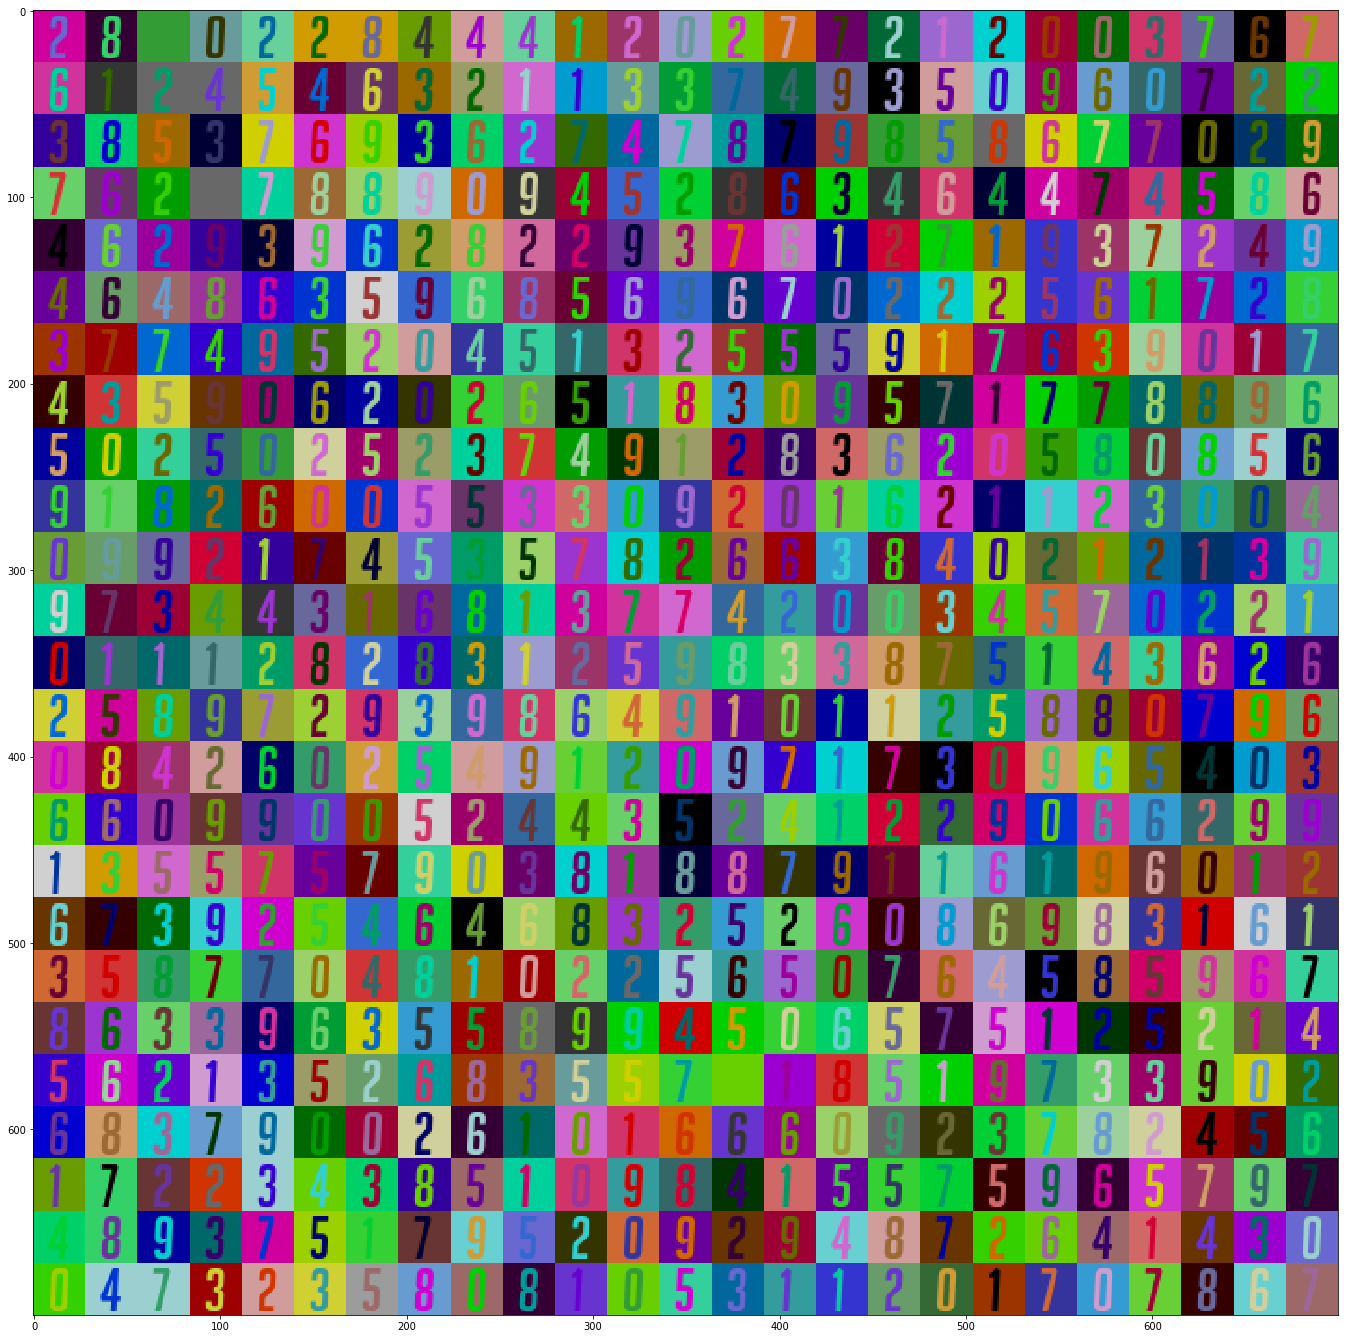

In [20]:
plt.rcParams['figure.figsize'] = (30.0, 24.0) # set default size of plots
h, w = canvas_size
n_rows, n_cols = 25, 25
display_grid = np.zeros( (n_rows*h, n_cols*w, 3) ).astype(np.uint8)

indices = random.sample(range(len(region_list)), n_rows * n_cols)
for idx, (row, col) in zip(indices, [(row, col) for row in range(n_rows) for col in range(n_cols)]):
    display_grid[row*h:row*h+h, col*w:col*w+w, :] = region_list[idx]
print("Number of generated images:", len(region_list))
plt.imshow(display_grid)

Grayscale the grid to visualize how the neural network would see the individual digits.

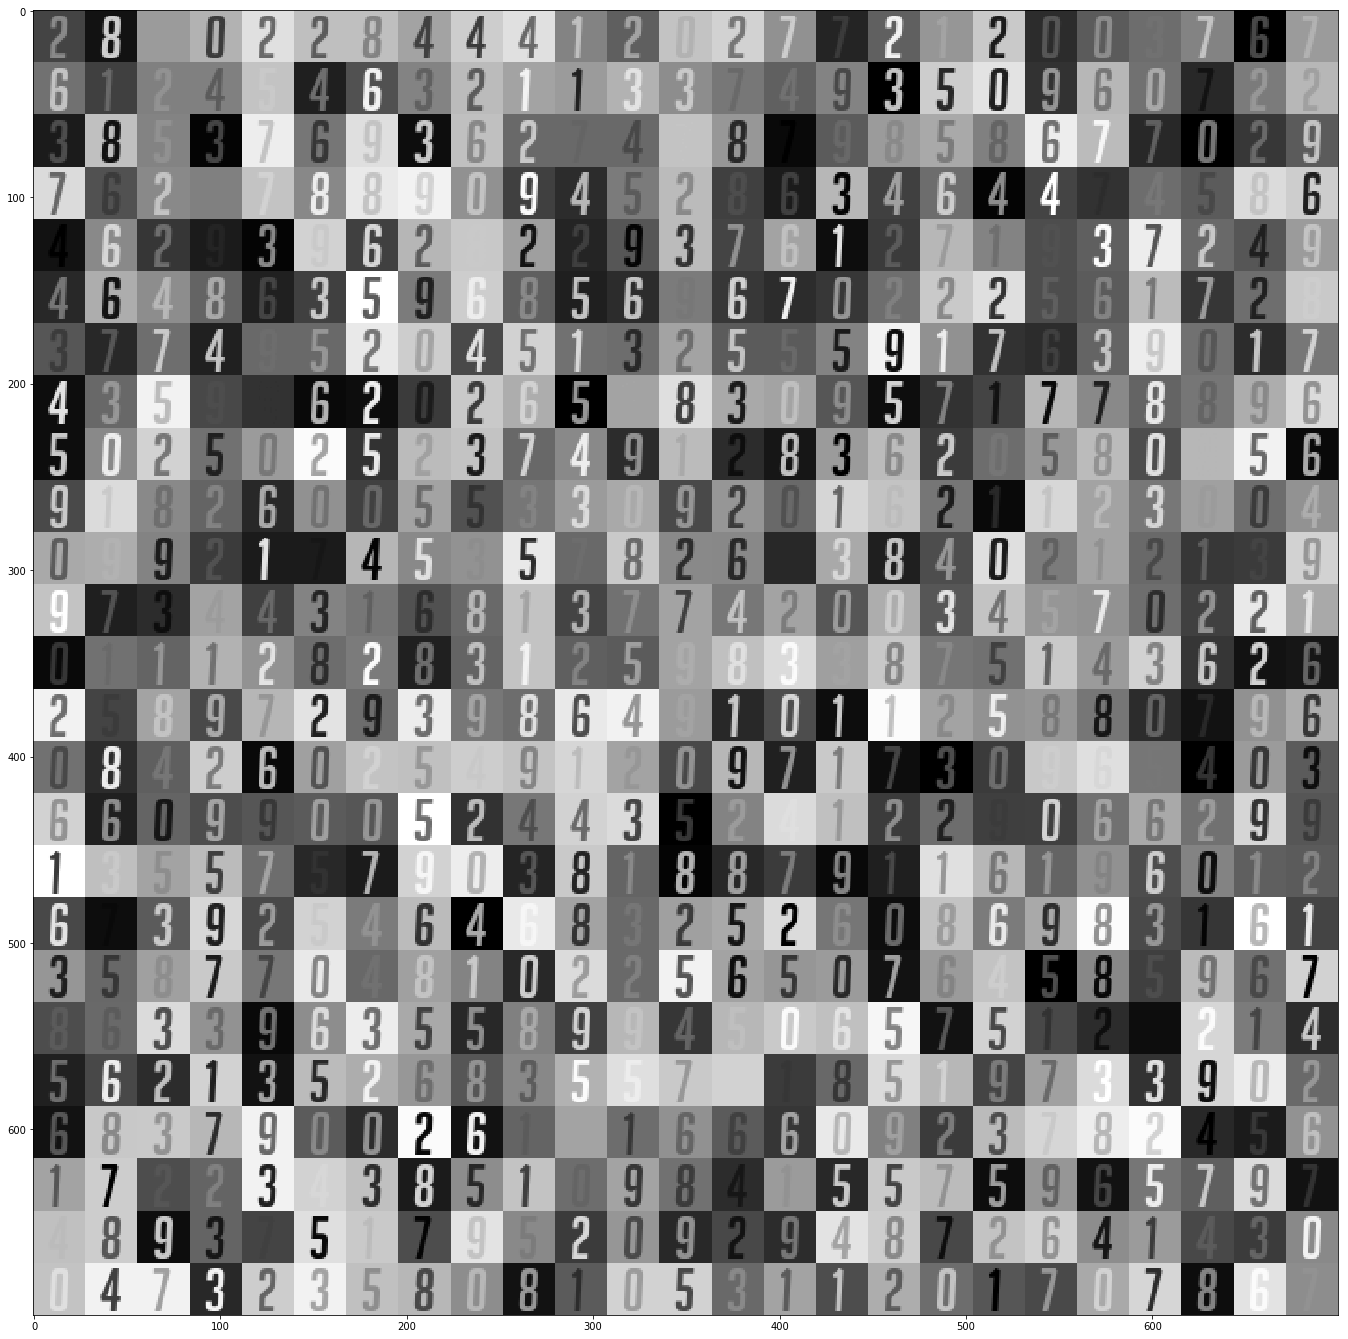

In [21]:
plt.imshow(color.rgb2gray(display_grid), cmap='gray')

# Further Exploration
* Generate synthetic data
    * shear digits so that they're straight and not italic 
* Fine-tune on synthetic data
* Run eval on real data

In [33]:
samples_per_digit = 60*10**3/10
num_canvas_colors = 60
text_colors = samples_per_digit / num_canvas_colors
print("canvas colors:", num_canvas_colors)
print("text colors:", text_colors)
print("Training samples per digit:", samples_per_digit)
canvas_color = (255, 255, 255)
plt.imshow

canvas colors: 60
text colors: 100.0
Training samples per digit: 6000.0


actual=5, predicted=3


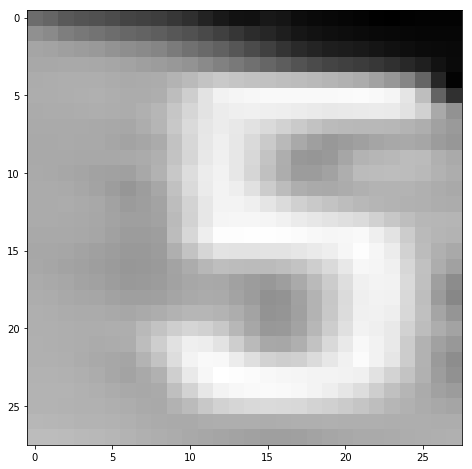

In [23]:
warped = cv2.resize(sheared_region, (28, 28), interpolation=cv2.INTER_LINEAR)
gray = color.rgb2gray(warped)
plt.imshow(gray, cmap='gray')
N, H, W, C = 1, 28, 28, 1
gray = gray.reshape(N, H, W, C)
result = model.predict(gray)
print("actual=%d, predicted=%d" % (5, np.argmax(result)))

Deserialized validation dataset from Pickle file.
(6749, 28, 28, 1)
Test loss: 2.27457418641
Test accuracy: 0.30122981178


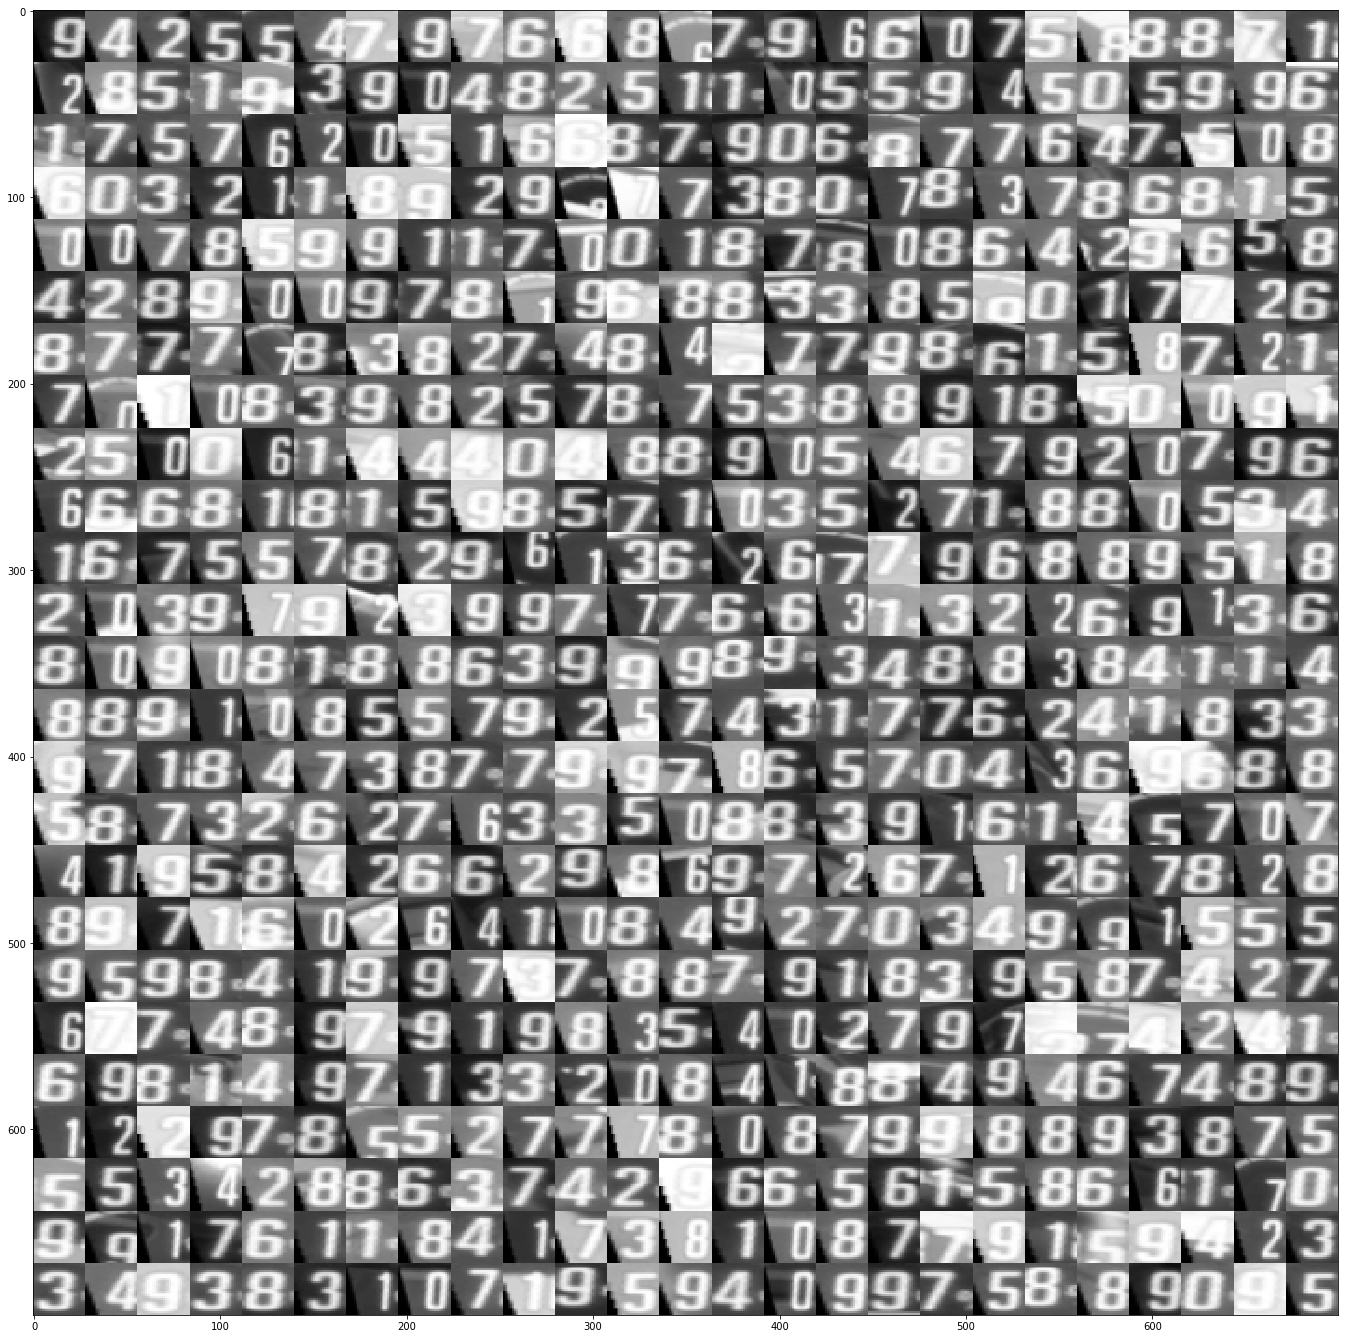

In [49]:
plt.rcParams['figure.figsize'] = (30.0, 24.0) # set default size of plots
x_valid, y_valid = load_straight_dataset(load_cached=True)
print(x_valid.shape)
plt.imshow(create_rand_grid(x_valid, 25, 25), cmap='gray')
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Deserialized validation dataset from Pickle file.
(6749, 28, 28, 1)
Test loss: 2.42502408127
Test accuracy: 0.2449251741


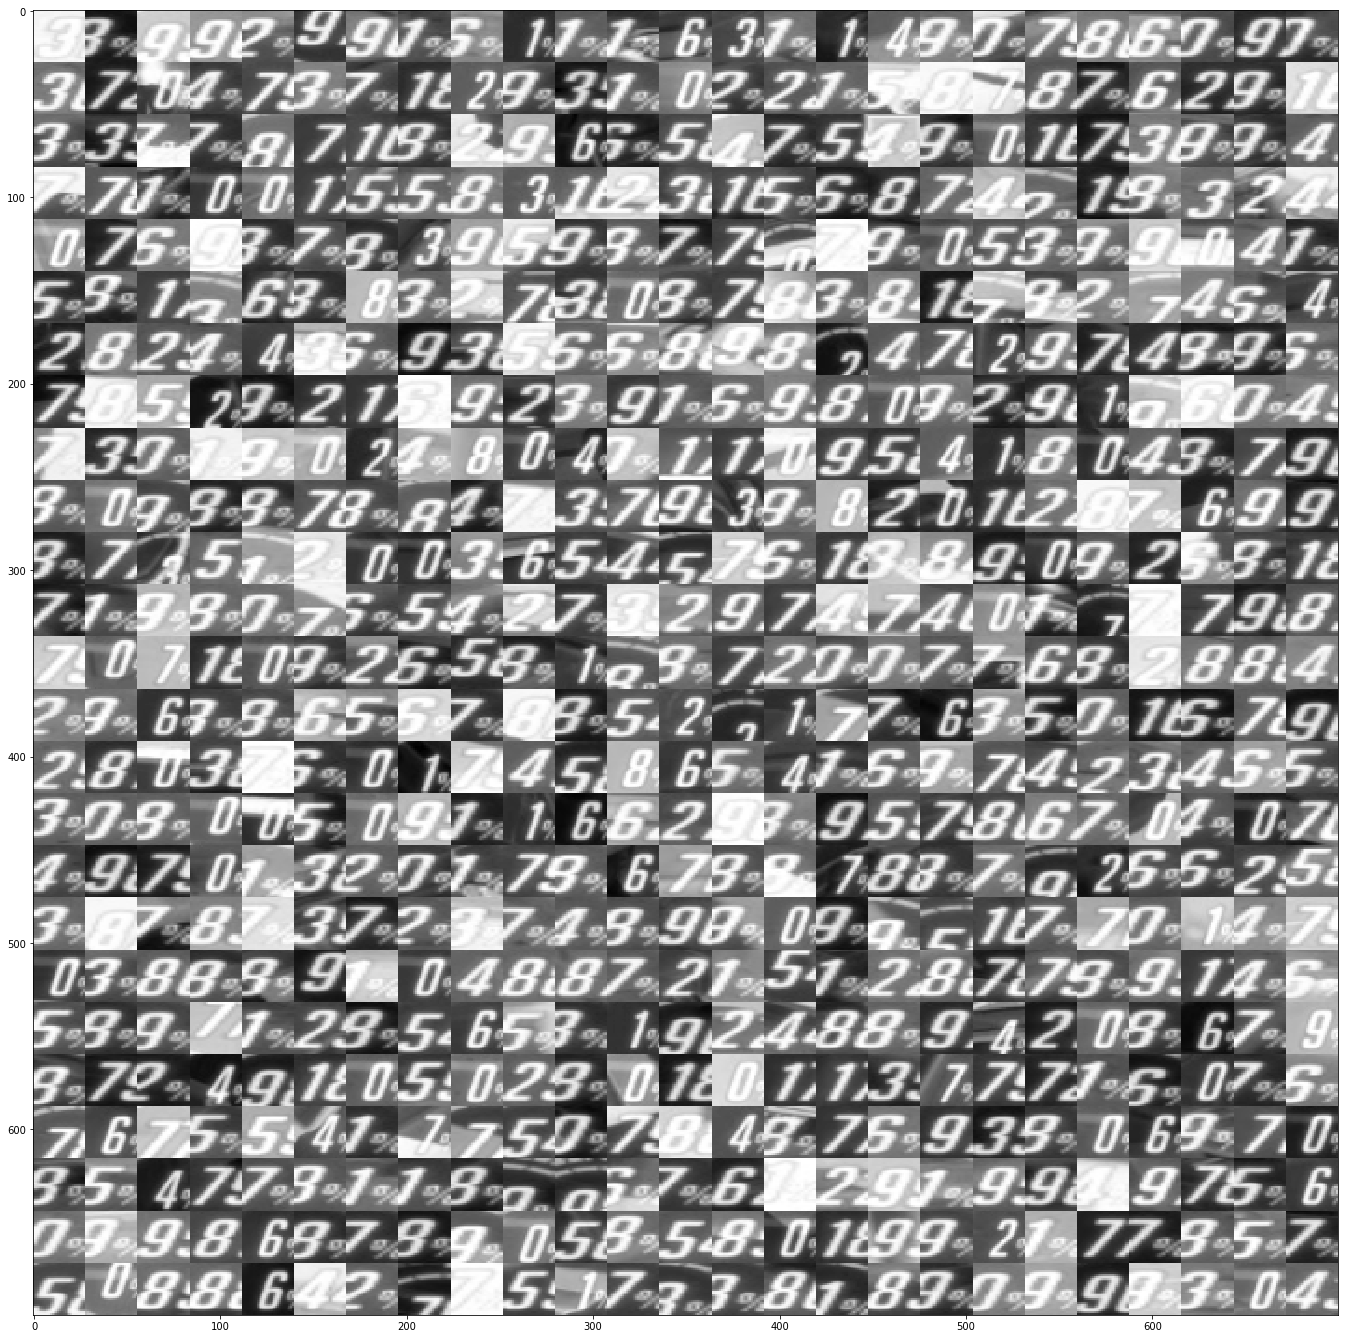

In [51]:
plt.rcParams['figure.figsize'] = (30.0, 24.0) # set default size of plots
x_valid, y_valid = load_slanted_dataset(load_cached=True)
print(x_valid.shape)
plt.imshow(create_rand_grid(x_valid, 25, 25), cmap='gray')
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

The straightened dataset has a 0.30122981178 accuracy, whereas the slanted dataset has a 0.2449251741 accuracy. The slanted dataset includes the percentage sign, so the bboxes need to be adjusted so that they're not included.

In [122]:
with open('results_sheared.csv', 'w') as f:
    for i, pair in enumerate(zip(x_valid, y_valid)):
        x, y = pair
        actual = np.argmax(y)
        predicted = np.argmax(model.predict(x.reshape(1, 28, 28, 1)))
        s = "[%d] actual=%d, predicted=%d\n" % (i, actual, predicted)
        print(s)
#         f.write("[%d] actual=%d, predicted=%d\n" % (i, actual, predicted))
print('Done')

[0] actual=5, predicted=8

[1] actual=9, predicted=0

[2] actual=5, predicted=5

[3] actual=9, predicted=3

[4] actual=5, predicted=5

[5] actual=9, predicted=3

[6] actual=5, predicted=5

[7] actual=9, predicted=3

[8] actual=5, predicted=2

[9] actual=9, predicted=2

[10] actual=5, predicted=5

[11] actual=9, predicted=3

[12] actual=5, predicted=5

[13] actual=9, predicted=3

[14] actual=5, predicted=5

[15] actual=9, predicted=3

[16] actual=5, predicted=5

[17] actual=9, predicted=3

[18] actual=5, predicted=5

[19] actual=9, predicted=3

[20] actual=5, predicted=5

[21] actual=9, predicted=7

[22] actual=5, predicted=5

[23] actual=9, predicted=3

[24] actual=5, predicted=5

[25] actual=9, predicted=9

[26] actual=5, predicted=5

[27] actual=9, predicted=3

[28] actual=5, predicted=5

[29] actual=9, predicted=3

[30] actual=5, predicted=5

[31] actual=9, predicted=3

[32] actual=5, predicted=5

[33] actual=9, predicted=3

[34] actual=5, predicted=5

[35] actual=9, predicted=8

[3

[330] actual=3, predicted=3

[331] actual=5, predicted=5

[332] actual=3, predicted=6

[333] actual=5, predicted=5

[334] actual=3, predicted=3

[335] actual=5, predicted=5

[336] actual=3, predicted=3

[337] actual=5, predicted=5

[338] actual=3, predicted=3

[339] actual=5, predicted=5

[340] actual=3, predicted=3

[341] actual=5, predicted=8

[342] actual=3, predicted=3

[343] actual=5, predicted=5

[344] actual=3, predicted=3

[345] actual=5, predicted=5

[346] actual=3, predicted=2

[347] actual=5, predicted=3

[348] actual=3, predicted=8

[349] actual=5, predicted=8

[350] actual=3, predicted=3

[351] actual=5, predicted=5

[352] actual=3, predicted=3

[353] actual=5, predicted=5

[354] actual=3, predicted=0

[355] actual=5, predicted=8

[356] actual=3, predicted=0

[357] actual=5, predicted=3

[358] actual=3, predicted=3

[359] actual=5, predicted=5

[360] actual=3, predicted=3

[361] actual=5, predicted=5

[362] actual=3, predicted=3

[363] actual=5, predicted=5

[364] actual=3

[633] actual=3, predicted=3

[634] actual=3, predicted=3

[635] actual=3, predicted=3

[636] actual=3, predicted=3

[637] actual=3, predicted=3

[638] actual=3, predicted=3

[639] actual=3, predicted=3

[640] actual=2, predicted=2

[641] actual=0, predicted=3

[642] actual=2, predicted=2

[643] actual=0, predicted=3

[644] actual=2, predicted=2

[645] actual=0, predicted=3

[646] actual=2, predicted=2

[647] actual=0, predicted=3

[648] actual=1, predicted=3

[649] actual=8, predicted=3

[650] actual=1, predicted=3

[651] actual=8, predicted=3

[652] actual=1, predicted=9

[653] actual=8, predicted=3

[654] actual=1, predicted=3

[655] actual=8, predicted=3

[656] actual=1, predicted=9

[657] actual=8, predicted=3

[658] actual=1, predicted=3

[659] actual=8, predicted=3

[660] actual=1, predicted=3

[661] actual=8, predicted=3

[662] actual=1, predicted=3

[663] actual=8, predicted=3

[664] actual=1, predicted=3

[665] actual=8, predicted=3

[666] actual=1, predicted=3

[667] actual=8

[994] actual=0, predicted=2

[995] actual=0, predicted=2

[996] actual=0, predicted=3

[997] actual=0, predicted=3

[998] actual=0, predicted=0

[999] actual=0, predicted=8

[1000] actual=0, predicted=3

[1001] actual=0, predicted=0

[1002] actual=0, predicted=2

[1003] actual=0, predicted=8

[1004] actual=0, predicted=2

[1005] actual=0, predicted=2

[1006] actual=0, predicted=0

[1007] actual=0, predicted=8

[1008] actual=0, predicted=3

[1009] actual=0, predicted=2

[1010] actual=0, predicted=0

[1011] actual=0, predicted=3

[1012] actual=0, predicted=0

[1013] actual=0, predicted=8

[1014] actual=0, predicted=2

[1015] actual=0, predicted=0

[1016] actual=0, predicted=2

[1017] actual=0, predicted=0

[1018] actual=0, predicted=2

[1019] actual=0, predicted=3

[1020] actual=0, predicted=8

[1021] actual=0, predicted=8

[1022] actual=0, predicted=1

[1023] actual=0, predicted=8

[1024] actual=0, predicted=0

[1025] actual=0, predicted=8

[1026] actual=0, predicted=8

[1027] actual=0,

[1300] actual=6, predicted=3

[1301] actual=1, predicted=3

[1302] actual=6, predicted=3

[1303] actual=1, predicted=3

[1304] actual=6, predicted=3

[1305] actual=1, predicted=3

[1306] actual=6, predicted=3

[1307] actual=1, predicted=3

[1308] actual=6, predicted=3

[1309] actual=1, predicted=3

[1310] actual=6, predicted=3

[1311] actual=1, predicted=3

[1312] actual=6, predicted=3

[1313] actual=1, predicted=9

[1314] actual=6, predicted=3

[1315] actual=1, predicted=3

[1316] actual=6, predicted=3

[1317] actual=1, predicted=3

[1318] actual=6, predicted=3

[1319] actual=1, predicted=3

[1320] actual=6, predicted=3

[1321] actual=1, predicted=3

[1322] actual=6, predicted=3

[1323] actual=1, predicted=3

[1324] actual=6, predicted=3

[1325] actual=1, predicted=3

[1326] actual=6, predicted=3

[1327] actual=1, predicted=3

[1328] actual=6, predicted=3

[1329] actual=1, predicted=3

[1330] actual=6, predicted=3

[1331] actual=1, predicted=3

[1332] actual=6, predicted=3

[1333] act

[1668] actual=7, predicted=2

[1669] actual=1, predicted=0

[1670] actual=7, predicted=3

[1671] actual=1, predicted=8

[1672] actual=7, predicted=2

[1673] actual=1, predicted=3

[1674] actual=7, predicted=2

[1675] actual=1, predicted=0

[1676] actual=7, predicted=3

[1677] actual=1, predicted=3

[1678] actual=7, predicted=2

[1679] actual=1, predicted=3

[1680] actual=7, predicted=2

[1681] actual=1, predicted=3

[1682] actual=7, predicted=2

[1683] actual=1, predicted=3

[1684] actual=7, predicted=2

[1685] actual=1, predicted=0

[1686] actual=7, predicted=3

[1687] actual=1, predicted=3

[1688] actual=7, predicted=2

[1689] actual=1, predicted=3

[1690] actual=7, predicted=2

[1691] actual=1, predicted=0

[1692] actual=1, predicted=0

[1693] actual=1, predicted=2

[1694] actual=1, predicted=0

[1695] actual=1, predicted=0

[1696] actual=1, predicted=0

[1697] actual=1, predicted=0

[1698] actual=1, predicted=0

[1699] actual=1, predicted=8

[1700] actual=1, predicted=0

[1701] act

[2024] actual=2, predicted=2

[2025] actual=1, predicted=2

[2026] actual=2, predicted=2

[2027] actual=1, predicted=2

[2028] actual=2, predicted=2

[2029] actual=1, predicted=2

[2030] actual=2, predicted=2

[2031] actual=1, predicted=3

[2032] actual=2, predicted=2

[2033] actual=1, predicted=3

[2034] actual=2, predicted=5

[2035] actual=1, predicted=3

[2036] actual=2, predicted=2

[2037] actual=1, predicted=2

[2038] actual=2, predicted=2

[2039] actual=1, predicted=2

[2040] actual=2, predicted=2

[2041] actual=1, predicted=3

[2042] actual=2, predicted=2

[2043] actual=1, predicted=3

[2044] actual=2, predicted=8

[2045] actual=1, predicted=6

[2046] actual=2, predicted=2

[2047] actual=1, predicted=2

[2048] actual=2, predicted=2

[2049] actual=1, predicted=2

[2050] actual=2, predicted=2

[2051] actual=1, predicted=2

[2052] actual=2, predicted=2

[2053] actual=1, predicted=2

[2054] actual=2, predicted=2

[2055] actual=1, predicted=3

[2056] actual=2, predicted=2

[2057] act

[2434] actual=3, predicted=3

[2435] actual=6, predicted=8

[2436] actual=3, predicted=3

[2437] actual=6, predicted=8

[2438] actual=3, predicted=3

[2439] actual=6, predicted=8

[2440] actual=3, predicted=3

[2441] actual=6, predicted=8

[2442] actual=3, predicted=3

[2443] actual=6, predicted=8

[2444] actual=3, predicted=3

[2445] actual=6, predicted=8

[2446] actual=3, predicted=3

[2447] actual=6, predicted=8

[2448] actual=3, predicted=3

[2449] actual=6, predicted=8

[2450] actual=3, predicted=3

[2451] actual=6, predicted=8

[2452] actual=3, predicted=0

[2453] actual=1, predicted=3

[2454] actual=3, predicted=0

[2455] actual=1, predicted=7

[2456] actual=3, predicted=0

[2457] actual=1, predicted=3

[2458] actual=3, predicted=6

[2459] actual=1, predicted=6

[2460] actual=3, predicted=0

[2461] actual=1, predicted=3

[2462] actual=3, predicted=8

[2463] actual=1, predicted=3

[2464] actual=3, predicted=5

[2465] actual=1, predicted=3

[2466] actual=3, predicted=0

[2467] act

[2773] actual=8, predicted=8

[2774] actual=9, predicted=8

[2775] actual=8, predicted=8

[2776] actual=9, predicted=8

[2777] actual=8, predicted=8

[2778] actual=9, predicted=8

[2779] actual=8, predicted=8

[2780] actual=9, predicted=5

[2781] actual=8, predicted=8

[2782] actual=9, predicted=8

[2783] actual=8, predicted=8

[2784] actual=9, predicted=6

[2785] actual=8, predicted=2

[2786] actual=9, predicted=8

[2787] actual=8, predicted=8

[2788] actual=9, predicted=8

[2789] actual=8, predicted=8

[2790] actual=9, predicted=8

[2791] actual=8, predicted=8

[2792] actual=9, predicted=8

[2793] actual=8, predicted=8

[2794] actual=9, predicted=8

[2795] actual=8, predicted=8

[2796] actual=9, predicted=6

[2797] actual=8, predicted=3

[2798] actual=9, predicted=8

[2799] actual=8, predicted=8

[2800] actual=9, predicted=8

[2801] actual=8, predicted=8

[2802] actual=9, predicted=8

[2803] actual=8, predicted=8

[2804] actual=9, predicted=8

[2805] actual=8, predicted=8

[2806] act

[3141] actual=9, predicted=3

[3142] actual=3, predicted=3

[3143] actual=9, predicted=8

[3144] actual=3, predicted=3

[3145] actual=9, predicted=3

[3146] actual=3, predicted=3

[3147] actual=9, predicted=3

[3148] actual=3, predicted=3

[3149] actual=9, predicted=3

[3150] actual=3, predicted=3

[3151] actual=9, predicted=3

[3152] actual=3, predicted=3

[3153] actual=9, predicted=3

[3154] actual=3, predicted=3

[3155] actual=9, predicted=3

[3156] actual=3, predicted=0

[3157] actual=9, predicted=3

[3158] actual=3, predicted=3

[3159] actual=9, predicted=3

[3160] actual=3, predicted=3

[3161] actual=9, predicted=3

[3162] actual=3, predicted=3

[3163] actual=9, predicted=3

[3164] actual=3, predicted=3

[3165] actual=9, predicted=3

[3166] actual=3, predicted=3

[3167] actual=9, predicted=3

[3168] actual=5, predicted=3

[3169] actual=2, predicted=3

[3170] actual=5, predicted=5

[3171] actual=2, predicted=3

[3172] actual=5, predicted=5

[3173] actual=2, predicted=3

[3174] act

[3522] actual=3, predicted=2

[3523] actual=3, predicted=0

[3524] actual=3, predicted=0

[3525] actual=3, predicted=2

[3526] actual=3, predicted=0

[3527] actual=3, predicted=2

[3528] actual=3, predicted=0

[3529] actual=3, predicted=0

[3530] actual=3, predicted=2

[3531] actual=3, predicted=2

[3532] actual=3, predicted=2

[3533] actual=3, predicted=0

[3534] actual=3, predicted=0

[3535] actual=3, predicted=0

[3536] actual=3, predicted=0

[3537] actual=3, predicted=8

[3538] actual=3, predicted=2

[3539] actual=3, predicted=2

[3540] actual=3, predicted=2

[3541] actual=3, predicted=2

[3542] actual=3, predicted=2

[3543] actual=3, predicted=2

[3544] actual=3, predicted=2

[3545] actual=3, predicted=0

[3546] actual=3, predicted=8

[3547] actual=3, predicted=2

[3548] actual=3, predicted=0

[3549] actual=3, predicted=2

[3550] actual=3, predicted=0

[3551] actual=3, predicted=2

[3552] actual=3, predicted=2

[3553] actual=3, predicted=2

[3554] actual=3, predicted=2

[3555] act

[3913] actual=2, predicted=3

[3914] actual=2, predicted=2

[3915] actual=2, predicted=3

[3916] actual=2, predicted=2

[3917] actual=2, predicted=3

[3918] actual=2, predicted=2

[3919] actual=2, predicted=3

[3920] actual=2, predicted=2

[3921] actual=2, predicted=3

[3922] actual=2, predicted=2

[3923] actual=2, predicted=3

[3924] actual=2, predicted=2

[3925] actual=2, predicted=3

[3926] actual=2, predicted=8

[3927] actual=2, predicted=3

[3928] actual=2, predicted=2

[3929] actual=2, predicted=3

[3930] actual=2, predicted=2

[3931] actual=2, predicted=3

[3932] actual=2, predicted=2

[3933] actual=2, predicted=3

[3934] actual=2, predicted=0

[3935] actual=2, predicted=2

[3936] actual=2, predicted=2

[3937] actual=2, predicted=3

[3938] actual=2, predicted=2

[3939] actual=2, predicted=3

[3940] actual=2, predicted=2

[3941] actual=2, predicted=3

[3942] actual=2, predicted=2

[3943] actual=2, predicted=3

[3944] actual=2, predicted=2

[3945] actual=2, predicted=3

[3946] act